## Deboost Bubbles

In [ ]:
cd '/home/dpirvu/project/paper_prefactor/'

In [2]:
import os,sys
sys.path.append('/home/dpirvu/python_stuff/')
sys.path.append('/home/dpirvu/project/paper_prefactor/bubble_codes/')
#sys.path.append('/home/dpirvu/project/paper_prefactor/bubble_codes_older/')
sys.path.remove('/home/dpirvu/DarkPhotonxunWISE/hmvec-master')
print(sys.path)
from plotting import *
from bubble_tools import *
from experiment import *
from celluloid import Camera

%matplotlib inline

['/home/dpirvu/project/paper_prefactor', '/cm/shared/apps/python/python37/lib/python37.zip', '/cm/shared/apps/python/python37/lib/python3.7', '/cm/shared/apps/python/python37/lib/python3.7/lib-dynload', '', '/home/dpirvu/.local/lib/python3.7/site-packages', '/cm/shared/apps/python/python37/lib/python3.7/site-packages', '/cm/shared/apps/python/python37/lib/python3.7/site-packages/IPython/extensions', '/home/dpirvu/.ipython', '/home/dpirvu/python_stuff/', '/home/dpirvu/project/paper_prefactor/bubble_codes/']
['/home/dpirvu/project/paper_prefactor', '/cm/shared/apps/python/python37/lib/python37.zip', '/cm/shared/apps/python/python37/lib/python3.7', '/cm/shared/apps/python/python37/lib/python3.7/lib-dynload', '', '/home/dpirvu/.local/lib/python3.7/site-packages', '/cm/shared/apps/python/python37/lib/python3.7/site-packages', '/cm/shared/apps/python/python37/lib/python3.7/site-packages/IPython/extensions', '/home/dpirvu/.ipython', '/home/dpirvu/python_stuff/', '/home/dpirvu/project/paper_pr

In [3]:
case = 'minus'
general = get_general_model(case)
tempList, massq, right_Vmax, V, dV, Vinv, nTimeMAX, minSim, maxSim = general

tmp = 2

maxSim = (1000 if tmp == 0 else 2000)
temp, m2, sigmafld = get_model(*general, tmp)
exp_params = [nLat, m2, temp]
print('Experiment', exp_params)

Experiment [2048, 0.7, 0.2]


In [4]:
def plot_zoomin(bubble, threshold=2., winsize=100, title=None):
    real = np.copy(bubble)
    real = real[0]
    nT, nN = np.shape(real)
    t_centre, x_centre = find_nucleation_center(real, phieq, crit_thresh, crit_rad)
    tl_stop, tr_stop = int(max(0, t_centre - winsize)), int(min(nT, t_centre + winsize//2))
    xl_stop, xr_stop = int(max(0, x_centre - winsize)), int(min(nN, x_centre + winsize))
    real = real[tl_stop:tr_stop, xl_stop:xr_stop]
    nT, nN = np.shape(real)
    tcen, xcen = find_nucleation_center(real, phieq, crit_thresh, crit_rad)
    t, x = np.linspace(-tcen, nT-1-tcen, nT), np.linspace(-xcen, nN-1-xcen, nN)
    real[np.abs(real) > threshold] = threshold
    simple_imshow([real], x, t, title=title, contour=False, ret=False)
    return

def simple_imshow_continue(ax, bubble, xList, tList, vmin, vmax, contour=False, title=None, aspect='auto', cmap='tab20c'):
    ext = [xList[0],xList[-1],tList[0],tList[-1]]
    im = ax.imshow(bubble, interpolation='none', extent=ext, vmin=vmin, vmax=vmax, aspect=aspect, origin='lower', cmap=cmap)
    if contour:
        ax.contour(xList, tList, bubble, levels=5, linewidths=0.5, colors='k')
    clb = plt.colorbar(im, ax = ax, shrink=0.5)
    ax.plot(0, 0, 'bo', ms=3)
    ax.set_title(title)
    return ax


In [5]:
crit_thresh = right_Vmax + 5.*sigmafld; print(crit_thresh)
peak_thresh = 2.8
tv_thresh   = 2.5
crit_rad    = 20

threshm, threshM = right_Vmax + 0.*sigmafld, right_Vmax + 4.*sigmafld
ampList = np.linspace(threshm, threshM, 12); print([round(ii, 2) for ii in ampList])

winsize = 200
plots= False

2.70793613122138
[1.0, 1.12, 1.25, 1.37, 1.5, 1.62, 1.75, 1.87, 1.99, 2.12, 2.24, 2.37]


In [6]:
dothis = False
if dothis:
    for sim in range(maxSim):
        path2cleansim = clean_sim_location(*exp_params, sim)
        path2RESTsim  = rest_sim_location(*exp_params, sim)
        if not os.path.exists(path2RESTsim): continue

        fullreal = np.load(path2cleansim, allow_pickle=True)
        _, _, totvel = np.load(path2RESTsim, allow_pickle=True)
        print(sim, totvel)

        bubble = np.copy(fullreal[0])
        bubble = np.abs(bubble)
        bubble = np.array([gaussian_filter(bubble, 2, mode='nearest')])

        nC, nT, nN = np.shape(bubble)
        tcen, xcen = find_nucleation_center(bubble[0], phieq, crit_thresh, crit_rad)
        tList = np.linspace(-tcen, nT-1-tcen, nT)
        xList = np.linspace(-xcen, nN-1-xcen, nN)

        test = fullreal[0, tcen, xcen-50:xcen+50]
        fig, ax = plt.subplots(1,1, figsize = (2.5,1.5))
        plt.plot(test)
        plt.show()

        if np.sign(np.mean(test)) < 0:
            print(sim, "changing sign")
            fullreal = -fullreal
        else:
            continue

        plot_zoomin(np.copy(fullreal), threshold=3, winsize=200, title='Original zoom')

        t, x, fullreal2save = boost_bubble(np.copy(fullreal), tcen, xcen, totvel)
        plot_zoomin(fullreal2save, threshold=3, winsize=200, title='Final zoom')

        np.save(path2RESTsim, np.array([sim, fullreal2save, totvel]))
        print('Saved sim', sim, 'total final velocity:', totvel)


In [7]:
remain2check = np.load('./plots/leftover_sims_2do_'+batch_params(*exp_params)+'.npy')
print(remain2check)

donothing = False
dothis = False
if dothis:
  #  for sim in range(minSim, maxSim):
    for si, sim in enumerate(remain2check):
        path2cleansim = clean_sim_location(*exp_params, sim)
        if not os.path.exists(path2cleansim): continue
        print('Starting simulation, temp:', sim, temp)

        fullreal = np.load(path2cleansim)
        nCfull, nTfull, nNfull = np.shape(fullreal)

        bubble = np.copy(fullreal[0])
        bubble = np.abs(bubble)
        bubble = np.array([gaussian_filter(bubble, 1., mode='nearest')])

        nC, nT, nN = np.shape(bubble)
        tcen, xcen = find_nucleation_center(bubble[0], phieq, crit_thresh, crit_rad)
        tList = np.linspace(-tcen, nT-1-tcen, nT)
        xList = np.linspace(-xcen, nN-1-xcen, nN)

        tcenfull, xcenfull = tcen, xcen
        tListfull = np.linspace(-tcenfull, nTfull-1-tcenfull, nTfull)
        xListfull = np.linspace(-xcenfull, nNfull-1-xcenfull, nNfull)

        test = fullreal[0, tcen, xcen-50:xcen+50]
        fig, ax = plt.subplots(1,1, figsize = (2.5,1.5))
        plt.plot(test)
        plt.show()

        bool, vellist = True, []
        if not donothing:
            try:
                vCOMmeas, varmeas = find_COM_vel(bubble, ampList, winsize, nLat, lightc, phieq, tv_thresh, crit_thresh, crit_rad, plots)
            except:
                print('Dunno. Dead end at step 0.')
            if np.isnan(vCOMmeas):
                print('Dead end at step 0.')
                bool = False

        st = 0
        doloop = False
        if doloop:
            while np.abs(vCOMmeas) >= 0.03 and bool:
                if len(vellist) > 0:
                    copy = np.copy(fullreal)[:1]

                    wcop = get_totvel_from_list(vellist)
                    x, t, copy = boost_bubble(copy, tcenfull, xcenfull, wcop)
                    vTest, _ = find_COM_vel(copy, ampList, winsize, nLat, lightc, phieq, tv_thresh, crit_thresh, crit_rad, False)
                    print('Upon testing this value, we re-measured vTest compared to vCOMmeas', vTest, vCOMmeas)
                    if np.abs(vTest) < 0.03:
                        vCOMmeas = vTest
                        break
                    if np.abs(vTest) > np.abs(vellist[-1]):
                        vCOMmeas = np.sign(vCOMmeas) * random.randint(5, 10)/10.

                st+=1
                vellist.append(vCOMmeas); print('Step', st, 'vels collected:', vellist);
                t, x, bubble = boost_bubble(bubble, tcen, xcen, vCOMmeas)

                vCOMmeas, varmeas = find_COM_vel(bubble, ampList, winsize, nLat, lightc, phieq, tv_thresh, crit_thresh, crit_rad, plots)
                if np.isnan(vCOMmeas):
                    print('Dead end.')
                    bool = False

        if bool:
            print('Simulation, temp:', sim, temp, 'doing final step.')
            if not donothing:
                vellist.append(vCOMmeas)
            else:
                vellist.append(0.)

            totvel = get_totvel_from_list(vellist)

            if np.sign(np.mean(test)) < 0:
                print(sim, "changing sign")
                fullreal = -fullreal

            plot_zoomin(np.copy(fullreal), threshold=peak_thresh, winsize=winsize, title='Original zoom')

            t, x, fullreal2save = boost_bubble(np.copy(fullreal), tcenfull, xcenfull, totvel)
            plot_zoomin(fullreal2save, threshold=peak_thresh, winsize=winsize, title='Final zoom')

            path2RESTsim = rest_sim_location(*exp_params, sim)
            np.save(path2RESTsim, np.array([sim, fullreal2save, totvel]))
            print('Saved sim', sim, 'total final velocity, vellist:', totvel, vellist)

    print('All Done.')

[   0    2    6 ... 1994 1996 1997]


In [8]:
remain2check = np.load('./plots/leftover_sims_2do_'+batch_params(*exp_params)+'.npy')
print(remain2check)

dothis = False
plotpairs = False

todolist = []
if dothis:
    for sim in remain2check:
  #  for sim in range(maxSim):
        path2RESTsim  = rest_sim_location(*exp_params, sim)
        path2cleansim = clean_sim_location(*exp_params, sim)

        if os.path.exists(path2cleansim):
            if not os.path.exists(path2RESTsim):
                todolist.append(sim)
            else:
                original = np.load(path2cleansim)
                sim, final, totvel = np.load(path2RESTsim, allow_pickle=True)
                print('Sim ', sim, 'total boost', totvel)

                if plotpairs:
                    fig, ax = plt.subplots(1, 2, figsize = (8,3))
                    for ii, bubble in enumerate([original, final]):
                        real = np.copy(bubble[0])
                        real = gaussian_filter(real, 1, mode='nearest')
                        real[np.abs(real) > crit_thresh] = crit_thresh
                        nT, nN = np.shape(real)

                        win = 200
                        tcen, xcen = find_nucleation_center(real, phieq, crit_thresh, crit_rad)
                        tl_stop, tr_stop = int(max(0, tcen - win)), int(min(nT, tcen + win//2))
                        xl_stop, xr_stop = int(max(0, xcen - win)), int(min(nN, xcen + win))
                        real = real[tl_stop:tr_stop, xl_stop:xr_stop]

                        nT, nN = np.shape(real)
                        tcen, xcen = find_nucleation_center(real, phieq, crit_thresh, crit_rad)
                        t, x = np.linspace(-tcen, nT-1-tcen, nT), np.linspace(-xcen, nN-1-xcen, nN)

                        if ii == 0: vmin, vmax = np.min(real), np.max(real)
                        simple_imshow_continue(ax[ii], real, x, t, vmin, vmax, contour=False)

                    beautify(ax, times=-70)
                    ax[1].grid(which='major', color='black', alpha=1)
                    ax[0].grid(which='major', color='black', alpha=1)
                    plt.title(r'${{\rm Sim \, }} {:.0f}, v_{{\rm COM}} = {:.3f}$'.format(sim, totvel))
                    plt.tight_layout()
                    plt.show()


[   0    2    6 ... 1994 1996 1997]


In [9]:
print(todolist)
savesims = False
if savesims:
    np.save('./plots/leftover_sims_2do_'+batch_params(*exp_params), todolist)
    remain2check = np.load('./plots/leftover_sims_2do_'+batch_params(*exp_params)+'.npy')
    print(len(remain2check))

[]


In [10]:
deletesims = True
if deletesims:
    for sim in []:
        path2RESTsim = rest_sim_location(*exp_params, sim)
        if os.path.exists(path2RESTsim):
            os.remove(path2RESTsim)

In [11]:
dothis = True
if dothis:
    path = decay_times_file(*exp_params, minSim, maxSim, nTimeMAX)
    if os.path.exists(path):
        print(path)
        decay_times = np.load(path)

        minDecTime = 256
        alltimes   = decay_times[:,1]
        simList2Do = decay_times[alltimes>=minDecTime, 0]

        all_vels = []
        for sim in simList2Do:
            path2RESTsim = rest_sim_location(*exp_params, sim)
            if os.path.exists(path2RESTsim):

                sim, bubble, totbeta = np.load(path2RESTsim, allow_pickle=True)
                all_vels.append(np.array([sim, totbeta]))

        np.save(velocities_file(*exp_params), all_vels)
  #  rm = np.load('./plots/changesignlist'+batch_params(*exp_params)+'.npy')
  #  print(len(all_vels) - len(rm), len(all_vels), len(simList2Do))
    print('Done!')


/gpfs/dpirvu/prefactor/x2048_m2eff0.7000_T0.2000_minSim0_maxSim2000_up_to_nTMax262144_timedecays.npy
Done!


0.2 828


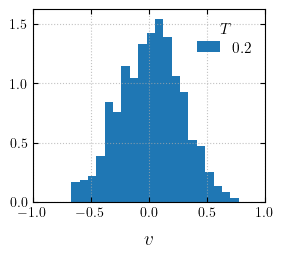

In [12]:
fig2, ax = plt.subplots(1, 1, figsize=(3, 2.5))

veldata = np.load(velocities_file(*exp_params))

simvels, all_vels = veldata[:,0].astype(int), veldata[:,1]
print(temp, len(simvels))

plt.hist(all_vels, bins=20, label=r'${:.1f}$'.format(temp), density=True)

plt.xlim((-1,1))
plt.xlabel(r'$v$')
beautify(ax, ttl=r'$T$', ncol=1, loc='best', times=-100)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


sphaleron solution total energy 1.3340080882032619
0.2 1.3340080882032619 1.3333333333333333
expectation 0.3872 actual std 0.2662


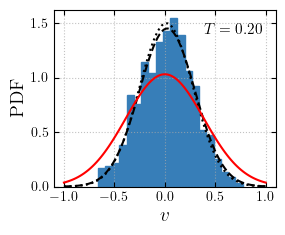

In [16]:
fig, ax = plt.subplots(1, 1, figsize = (3.,2.5))
cols=cycle(allcolors)

veldata = np.array(np.load(velocities_file(*exp_params)))
simvels, all_vels = veldata[:,0].astype(int), veldata[:,1]

col = next(cols)
n, bins, patches = ax.hist(all_vels, bins=20, alpha=1, color=col, density=True, ec=col)
n = n[1:]
bins = bins[1:]
centers = 0.5*(bins[1:] + bins[:-1])
xlist = np.linspace(-1., 1, 100)

gauss_fit = lambda x, mean, std: np.exp(- (x - mean)**2. / (2.*std**2.)) / np.sqrt(2.*np.pi*std**2.)
fit_gauss = lambda x, data: sco.curve_fit(gauss_fit, x, data)[0]
best_gauss = fit_gauss(centers, n)
ax.plot(xlist, gauss_fit(xlist, *best_gauss), color='k', ls='--')
ax.plot(xlist, gauss_fit(xlist, np.mean(all_vels), np.std(all_vels)), color='k', ls=':')

try:
    instanton = np.load(ansol_instanton_file(*exp_params))
    gradinst  = (np.roll(instanton,-1) - instanton)/dx
    instantonenergy = dx * np.sum(V(instanton) + 0.5*gradinst**2., axis=0)
    print('sphaleron solution total energy', instantonenergy)

    print(temp, instantonenergy, 4/3)
    bb = (temp/instantonenergy)**0.5
    ax.plot(xlist, gauss_fit(xlist, 0., bb), color='r', ls='-')
    print('expectation', round(bb, 4), 'actual std', round(np.std(all_vels), 4))
except:
    print('no instanton file yet.')

beautify(ax, times=-80, ttl=r'$T={:.2f}$'.format(temp))
ax.set_xlabel(r'$v$')
ax.set_ylabel(r'$\rm PDF$')
plt.tight_layout()
plt.savefig('./plots/comparison_vels_PDF.pdf')
plt.show()
